# NER with a Dictionary

This is a naive approach of NER using a fixed list of medical terms and names of diseases. Basically, the NER will be as good as good is the list. I have used a scrapper to obtain a little list of diseases (in English), I did a bit of manual parsing on the list and store them in the file `diseases.txt`. My goal is to see how good can be an algorithm based on such list.

A simlar approch is creating a list of Regular Expression for a particular language. Obviously, a person must create those patterns, so it can be hard to maintain a big list of patterns.

In [1]:
import re
import string
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import en_core_web_sm
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_SET

In [2]:
DATA_PATH = '../data/'
PARSED_DATA_PATH = DATA_PATH + 'parsed/'
SPLIT_CHAR = ' '

corpus_test_file = 'corpus_test.txt'
bin_corpus_test_file = 'bin_corpus_test.txt'
diseases_file = 'diseases.txt'

with open(PARSED_DATA_PATH + corpus_test_file, 'r') as fp:
    test_dataset = fp.readlines()

with open(PARSED_DATA_PATH + bin_corpus_test_file, 'r') as fp:
    bin_test_dataset = fp.readlines()
    bin_test_dataset = [s.strip().split(SPLIT_CHAR) if s.strip() != '' else [] for s in bin_test_dataset]
    bin_test_dataset = [np.array(s).astype('int') for s in bin_test_dataset]

with open(DATA_PATH + diseases_file, 'r') as fp:
    diseases = fp.readlines()

In [3]:
def get_nlp_engine(basic_tokenizer=False):
    if basic_tokenizer:
        nlp = English()
    else:
        nlp = en_core_web_sm.load()
    return nlp

In [4]:
def tokenize_texts(texts, basic_tokenizer=False):
    texts = texts.copy()
    nlp = get_nlp_engine(basic_tokenizer=basic_tokenizer)
    
    for index, text in enumerate(texts):
        nlp_tokens = nlp(text)
        
        pos = [w.pos_ for w in nlp_tokens]
        lemmas = [w.lemma_.strip() if w.lemma_ != "-PRON-" else w.lower_.strip() for w in nlp_tokens]
        lemmas = [w if any(c.isupper() for c in w) else w for w in lemmas]
        
        # Remove empty tokens
        tokens = [(lemmas[i].strip(), pos[i], nlp_tokens[i]) for i in range(len(nlp_tokens)) if lemmas[i].strip() != '']
        
        texts[index] = tokens
    
    return texts

In [5]:
diseases = tokenize_texts(diseases)
test_dataset = tokenize_texts(test_dataset)

tok_diseases = [[d[0] for d in disease] for disease in diseases]
tok_test_dataset = [[d[0] for d in text] for text in test_dataset]

## Find diseases in texts

I compute the "intersection" of the list of diseases with the texts of the dataset. If there is a *match*, I store $1$ in an array (otherwise I store $0$). In the end, I will have a sequence of 1s and 0s, so I can compare it with the real labels.

In [6]:
def get_maxbin_dataset(tokenized_dataset, tok_diseases):
    ignored_tokens = list(STOP_WORDS_SET) + list(string.punctuation)

    special_separators = re.compile(r'^[0-9_\-\\/]+$')

    bin_entities_per_text = []

    for tokens in tokenized_dataset:
        len_tokens = len(tokens)

        bin_entities = np.zeros(len_tokens, dtype=int)

        # Find diseases coincidences
        for index, token in enumerate(tokens):
            if token in ignored_tokens or special_separators.match(token):
                # Ignore certain tokens
                continue

            for disease_tokens in tok_diseases:
                if token in disease_tokens:
                    bin_entities[index] = 1
                    break

        # Given a token with matches as a disease, if the next token is a "certain separator", then add it
        # as a coincidence as well as the next token to the separator. Idem. with previous tokens.

        # Forward
        for i in range(2, len_tokens):
            if special_separators.match(tokens[i - 1]) and bin_entities[i - 2] == 1:
                bin_entities[i - 1] = 1
                bin_entities[i] = 1

        # Backwards
        for i in range(len_tokens - 2):
            if special_separators.match(tokens[i + 1]) and bin_entities[i + 2] == 1:
                bin_entities[i + 1] = 1
                bin_entities[i] = 1

        bin_entities_per_text.append(bin_entities)
    
    return bin_entities_per_text

In [7]:
pred_bin_test_dataset = get_maxbin_dataset(tok_test_dataset, tok_diseases)

In [8]:
# Quick overview of a prediction and the expected output
print(pred_bin_test_dataset[0])
print(bin_test_dataset[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0]


## Evaluation

A quick comparison show us the we are not detecting all the entities that we should be identify. On the one hand, I am not getting "false entities" (only around $2\%$) which it is pretty good. On the other hand, I only find around $27\%$ entities (very low).

It is not a really bad result for such small dictionary `diseases.txt`.

In [9]:
def confusion_matrix(real_bin_dataset, pred_bin_dataset):
    if len(real_bin_dataset) != len(pred_bin_dataset):
        raise Exception('Different lengths in lists: %d vs %d' % (len(real_bin_dataset), len(pred_bin_dataset)))
    
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    
    text_i = 0
    len_texts = len(real_bin_dataset)
    
    while text_i < len_texts:
        token_i = 0
        len_text = len(real_bin_dataset[text_i])
        
        while token_i < len_text:
            if real_bin_dataset[text_i][token_i] == 1:
                tp = tp + int(pred_bin_dataset[text_i][token_i] == 1)
                fn = fn + int(pred_bin_dataset[text_i][token_i] == 0)
            else:
                fp = fp + int(pred_bin_dataset[text_i][token_i] == 1)
                tn = tn + int(pred_bin_dataset[text_i][token_i] == 0)
            token_i = token_i + 1

        text_i = text_i + 1
    
    return np.array([[tn, fp], [fn, tp]])

In [10]:
def plot_confusion_matrix(conf_matrix, normalize=True):
    conf_matrix = copy.deepcopy(conf_matrix)
    
    if normalize:
        conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
    
    label_names = ['Bad', 'Good']
    df_confusion_matrix = pd.DataFrame(conf_matrix,
                                       index=label_names, 
                                       columns=label_names)

    plt.figure(figsize=(5, 5))
    sns.heatmap(df_confusion_matrix, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

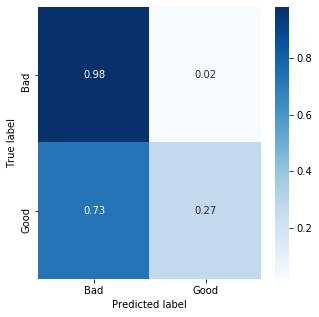

In [11]:
cm = confusion_matrix(bin_test_dataset, pred_bin_test_dataset)
plot_confusion_matrix(cm)

## Make a prediction

In [12]:
def bin_pred_to_str(nlp_text, bin_pred):
    i = 0
    
    text_length = len(nlp_text)
    entities = []

    # Get list of entities separately
    entities_stack = []
    while i < text_length:
        if bin_pred[i]:
            entities_stack.append((i, nlp_text[i][2].text_with_ws))
        i = i + 1

    # Concatenate consecutive entities
    last_pos = None
    for e in entities_stack:
        if last_pos == e[0] - 1:
            last_pos = e[0]
            n_entities = len(entities) - 1
            entities[n_entities] = entities[n_entities] + e[1]
        else:
            last_pos = e[0]
            entities.append(e[1])

    entities = [e.strip() for e in entities]        
    
    return entities

In [13]:
def get_entities(text, tok_diseases):
    # Put the previous text inside of a list
    texts = list([text])

    # Tokenize it and get PoS tags
    nlp_text = tokenize_texts(texts)[0]
    
    tok_text = list([[w[0] for w in nlp_text]])
    pred_bin_text = get_maxbin_dataset(tok_text, tok_diseases)[0]
    
    pred_str_entities = bin_pred_to_str(nlp_text, pred_bin_text)
    
    return pred_str_entities

In [14]:
text = 'Clustering of missense mutations in the ataxia-telangiectasia gene in a sporadic T-cell leukaemia .'

pred_str_entities = get_entities(text, tok_diseases)

print(pred_str_entities)

['T-cell leukaemia']


In [15]:
text = 'The patient has been diagnosed with scoliosis.'

pred_str_entities = get_entities(text, tok_diseases)

print(pred_str_entities)

['scoliosis']
